**Task VI: Quantum representation learning**

In this task you should implement a simple representation learning scheme based on a contrastive loss:
Load the MNIST dataset
Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations
Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.


PennyLane version: 0.40.0
Epoch 1/10, Loss: 5.4375
Epoch 2/10, Loss: 5.4375
Epoch 3/10, Loss: 5.4375
Epoch 4/10, Loss: 5.4375
Epoch 5/10, Loss: 5.4375
Epoch 6/10, Loss: 5.4375
Epoch 7/10, Loss: 5.4375
Epoch 8/10, Loss: 5.4375
Epoch 9/10, Loss: 5.4375
Epoch 10/10, Loss: 5.4375


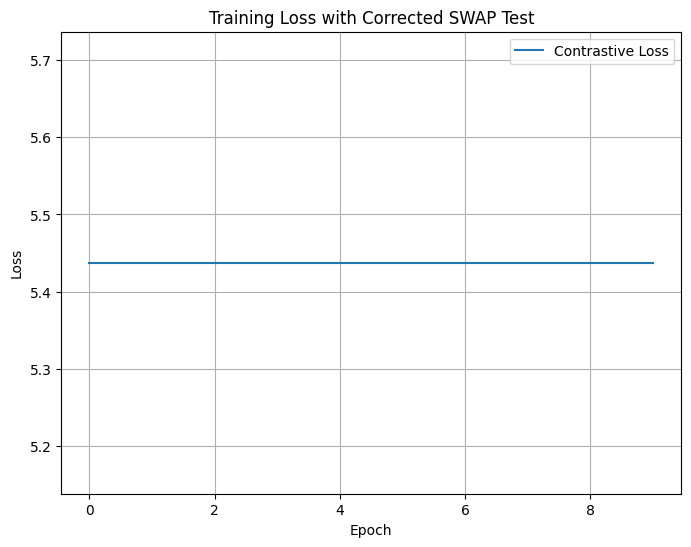

In [ ]:
!pip install pennylane
import tensorflow as tf
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_flat = x_train.reshape((len(x_train), 784))
x_test_flat = x_test.reshape((len(x_test), 784))

num_samples = 200
x_train_subset = x_train_flat[:num_samples]
y_train_subset = y_train[:num_samples]

num_test_samples = 50
x_test_subset = x_test_flat[:num_test_samples]
y_test_subset = y_test[:num_test_samples]

num_qubits_per_image = 3
num_qubits_total = 2 * num_qubits_per_image + 1
dev = qml.device('default.qubit', wires=num_qubits_total)

def quantum_state_preparation(image_features, qubits_register, trainable_params):
    for i, qubit in enumerate(qubits_register):
        param_rx = trainable_params[i]
        qml.RX(param_rx * np.pi * image_features[i], wires=qubit)

@qml.qnode(dev, interface='tf')
def swap_test_circuit(image1_features, image2_features, qubits_image1, qubits_image2, ancilla_qubit_wire, trainable_params):
    quantum_state_preparation(image1_features, qubits_image1, trainable_params[:num_qubits_per_image])
    quantum_state_preparation(image2_features, qubits_image2, trainable_params[num_qubits_per_image:])
    qml.Hadamard(wires=ancilla_qubit_wire)
    for i in range(num_qubits_per_image):
        qml.CSWAP(wires=[ancilla_qubit_wire, qubits_image1[i], qubits_image2[i]])
    qml.Hadamard(wires=ancilla_qubit_wire)
    return qml.expval(qml.PauliZ(ancilla_qubit_wire))

def contrastive_loss(fidelity, labels_pair):
    label1, label2 = labels_pair
    same_class = tf.cast(tf.equal(label1, label2), dtype=tf.float32)
    loss = tf.where(tf.equal(same_class, 1.0), tf.square(1.0 - fidelity), tf.square(fidelity))
    return tf.reduce_mean(loss)

num_trainable_params = 2 * num_qubits_per_image
epochs = 10
batch_size = 32
learning_rate = 0.01

qubits_image1 = list(range(num_qubits_per_image))
qubits_image2 = list(range(num_qubits_per_image, 2 * num_qubits_per_image))
ancilla_qubit_wire = 2 * num_qubits_per_image

trainable_params = tf.Variable(tf.random.normal([num_trainable_params]))
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def create_data_pairs(x_data, y_data, batch_size):
    pairs = []
    labels = []
    num_classes = len(np.unique(y_data))
    digit_indices = [np.where(y_data == i)[0] for i in range(num_classes)]
    for i in range(len(x_data)):
        digit = y_data[i]
        same_class_indices = digit_indices[digit]
        partner_index = np.random.choice(same_class_indices[same_class_indices != i])
        pairs += [[x_data[i], x_data[partner_index]]]
        labels += [(y_data[i], y_data[partner_index])]
        if num_classes > 1:
            diff_digit = (digit + np.random.randint(1, num_classes)) % num_classes
            diff_class_indices = digit_indices[diff_digit]
            diff_partner_index = np.random.choice(diff_class_indices)
            pairs += [[x_data[i], x_data[diff_partner_index]]]
            labels += [(y_data[i], y_data[diff_digit])]
    pairs = np.array(pairs)
    labels = np.array(labels)
    indices = np.arange(len(pairs))
    np.random.shuffle(indices)
    pairs = pairs[indices]
    labels = labels[indices]
    num_batches = len(pairs) // batch_size
    batched_pairs = np.array_split(pairs[:num_batches * batch_size], num_batches)
    batched_labels = np.array_split(labels[:num_batches * batch_size], num_batches)
    return batched_pairs, batched_labels

batched_train_pairs, batched_train_labels = create_data_pairs(x_train_subset, y_train_subset, batch_size)

history = {'loss': []}

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_pairs, batch_labels in zip(batched_train_pairs, batched_train_labels):
        batch_losses = []
        for pair_images, pair_labels in zip(batch_pairs, batch_labels):
            image1_features = pair_images[0][:num_qubits_per_image]
            image2_features = pair_images[1][:num_qubits_per_image]
            with tf.GradientTape() as tape:
                fidelity_output_tensor = swap_test_circuit(image1_features, image2_features, qubits_image1, qubits_image2, ancilla_qubit_wire, trainable_params)
                fidelity = tf.reshape(fidelity_output_tensor, [])
                loss_value = contrastive_loss(fidelity, pair_labels)
            gradients = tape.gradient(loss_value, trainable_params)
            optimizer.apply_gradients([(gradients, trainable_params)])
            batch_losses.append(loss_value.numpy())
        epoch_loss += np.mean(batch_losses)
    history['loss'].append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Corrected SWAP Test')
plt.legend()
plt.grid(True)
plt.show()


